# **Analise de temas narrativos e emocionais em  STAR WARS: THE CLONE WARS**

# 1. Metodologia e Técnicas Utilizadas

## 1.1 Processamento de Linguagem Natural (NLP)
- Tokenização de sentenças e limpeza de texto com NLTK
- Remoção de tags de formatação e normalização de scripts
- Processamento de legendas em formato SRT

## 1.2 Classificação de Temas
- Zero-shot classification (`facebook/bart-large-mnli`) para identificação de temas por episódio

## 1.3 Agregação e Visualização
- Média de pontuação por temporada para identificar tendências
- Gráficos de evolução de temas ao longo das temporadas
- Destaque visual de padrões e mudanças de intensidade de temas
- Análise comparativa entre temporadas


In [ ]:
from google.colab import files
import zipfile
import os

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.rar to data.rar


In [ ]:
!mkdir -p data
!unrar x data.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from data.rar

Creating    data/subs                                                 OK
Extracting  data/subs/The Clone Wars Season 1 - 01.srt                     0%  OK 
Extracting  data/subs/The Clone Wars Season 1 - 02.srt                     1%  OK 
Extracting  data/subs/The Clone Wars Season 1 - 03.srt                     2%  OK 
Extracting  data/subs/The Clone Wars Season 1 - 04.srt                     3%  OK 
Extracting  data/subs/The Clone Wars Season 1 - 05.srt                     4%  OK 
Extracting  data/subs/The Clone Wars Season 1 - 06.srt                     5%  OK 
Extracting  data/subs/The Clone Wars Season 1 - 07.srt                     5%  OK 
Extracting  data/subs/The Clone Wars Season 1 - 08.srt                     6%  OK 
Extracting  data/subs/The Clone Wars Season 1 - 09.srt                     7%  O

## Importando as bilbliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from transformers import pipeline
from nltk import sent_tokenize
import nltk
from time import time
import matplotlib.pyplot as plt
import torch
import re
import chardet

## Download dos Tokenizers do NLTK

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# 2. Coleta e Pré-processamento de Dados

In [ ]:
subtitles_path = sorted(glob("data/subs/*.srt"))

In [ ]:
subtitles_path[:5]

['data/subs/The Clone Wars Season 1 - 01.srt',
 'data/subs/The Clone Wars Season 1 - 02.srt',
 'data/subs/The Clone Wars Season 1 - 03.srt',
 'data/subs/The Clone Wars Season 1 - 04.srt',
 'data/subs/The Clone Wars Season 1 - 05.srt']

In [ ]:
def load_and_process_subtitles(subtitles_path):
    scripts = []
    episode_num = []
    season_num = []

    for path in subtitles_path:
        with open(path, 'rb') as file:
            raw_data = file.read()
            encoding = chardet.detect(raw_data)['encoding']

        with open(path, 'r', encoding=encoding) as file:
            content = file.read()

        content = content.replace('<i>', '').replace('</i>', '') # Remove tags de itálico das legendas
        subtitle_blocks = content.strip().split('\n\n')

        text_lines = []
        for block in subtitle_blocks:
            lines = block.split('\n')
            if len(lines) > 2:
                block_text = ' '.join(lines[2:])
                text_lines.append(block_text)

        script = ' '.join(text_lines).replace('\n', ' ').replace('  ', ' ')

        filename = path.split('\\')[-1]
        match = re.search(r'Season\s+(\d+)\s*-\s*(\d+)', filename)

        if match:
            season = int(match.group(1))
            episode = int(match.group(2))

        scripts.append(script)
        episode_num.append(episode)
        season_num.append(season)

    return pd.DataFrame({
    'season': season_num,
    'episode': episode_num,
    'script': scripts
    })

In [ ]:
df = load_and_process_subtitles(subtitles_path)
df = df.sort_values(['season', 'episode']).reset_index(drop=True)
df.head()

,season,episode,script
0,1,1,A galaxy divided by war. Peaceful worlds must ...
1,1,2,The clone Starfleet is under siege. Dozens of ...
2,1,3,A deadly weapon unleashed. The Separatist batt...
3,1,4,Grievous in retreat! Before the battleship Mal...
4,1,5,Clone forces rally. As the war escalates in th...


In [ ]:
print(f"Total de episódios: {len(df)}")
print(f"Temporadas: {df['season'].unique()}")
print(f"Episódios por temporada:")
print(df['season'].value_counts().sort_index())

Total de episódios: 133
Temporadas: [1 2 3 4 5 6 7]
Episódios por temporada:
season
1    22
2    22
3    22
4    22
5    20
6    13
7    12
Name: count, dtype: int64


# 3. Carregando o modelo

In [ ]:
device = 0 if torch.cuda.is_available() else 'cpu'

In [ ]:
from transformers import pipeline
theme_classifier = pipeline("zero-shot-classification",
                      model= 'facebook/bart-large-mnli',
                      device=device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [ ]:
theme_classifier("The hyperdrive on my Millennium Falcon is malfunctioning during the escape from Hoth!",
    candidate_labels=["urgent", "not urgent", "rebel", "empire", "smuggler", "droid"],
    multi_label=False
)

{'sequence': 'The hyperdrive on my Millennium Falcon is malfunctioning during the escape from Hoth!',
 'labels': ['urgent', 'rebel', 'smuggler', 'empire', 'droid', 'not urgent'],
 'scores': [0.5670729875564575,
  0.15721166133880615,
  0.1438969373703003,
  0.10840361565351486,
  0.014750132337212563,
  0.008664666675031185]}

# 4. Inferência e processamento de temas

In [ ]:
def get_themes_clone_wars(script):
    script_sentences = sent_tokenize(script)

    script_batches = []
    sentence_batch_size = 10
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)

    emotion_output = theme_classifier(script_batches, themes, multi_label=True)

    emotions = {}
    for output in emotion_output:
        for label, score in zip(output['labels'], output['scores']):
            if score < 0.3:
                continue
            if label not in emotions:
                emotions[label] = []
            emotions[label].append(score)

    emotions = {key: np.mean(np.array(value)) for key, value in emotions.items()}
    return emotions

In [ ]:
themes = [
    'war',
    'honor',
    'loyalty',
    'betrayal',
    'strategy',
    'sacrifice',
    'friendship',
    'hope',
    'corruption',
    'justice',
    'power',
    'duty',
]

In [ ]:
from tqdm import tqdm
tqdm.pandas()

season_themes = {}

for season in df['season'].unique():
    print(f"Processando Temporada {season}...")
    season_df = df[df['season'] == season]

    season_emotions = season_df['script'].progress_apply(get_themes_clone_wars)
    emotion_df_season = pd.DataFrame(season_emotions.tolist())

    theme_scores = emotion_df_season.mean().reset_index()
    theme_scores.columns = ['theme', 'score']
    theme_scores = theme_scores.sort_values('score', ascending=False)

    season_themes[season] = theme_scores
    print(f"Temporada {season} concluída!")

Processando Temporada 1...


100%|██████████| 22/22 [04:32<00:00, 12.36s/it]


Temporada 1 concluída!
Processando Temporada 2...


100%|██████████| 22/22 [04:13<00:00, 11.51s/it]


Temporada 2 concluída!
Processando Temporada 3...


100%|██████████| 22/22 [03:44<00:00, 10.21s/it]


Temporada 3 concluída!
Processando Temporada 4...


100%|██████████| 22/22 [03:31<00:00,  9.61s/it]


Temporada 4 concluída!
Processando Temporada 5...


100%|██████████| 20/20 [03:22<00:00, 10.13s/it]


Temporada 5 concluída!
Processando Temporada 6...


100%|██████████| 13/13 [02:17<00:00, 10.54s/it]


Temporada 6 concluída!
Processando Temporada 7...


100%|██████████| 12/12 [02:05<00:00, 10.46s/it]

Temporada 7 concluída!


# 5. Visualização de temas

In [ ]:
plt.style.use('bmh')
sns.set_palette("tab20", len(themes))

def plot_season_themes(season_themes, themes):
  comparison_data = []
  for season, themes_df in season_themes.items():
      for _, row in themes_df.iterrows():
          comparison_data.append({
              'season': season,
              'theme': row['theme'],
              'score': row['score']
          })

  comparison_df = pd.DataFrame(comparison_data)

  plt.figure(figsize=(14, 8))
  sns.barplot(data=comparison_df, x='theme', y='score', hue='season', palette='Paired')
  plt.title('Evolução de Temas por Temporada - The Clone Wars', fontweight='bold')
  plt.xticks(rotation=45)
  plt.legend(title='Temporada')
  plt.tight_layout()
  plt.show()

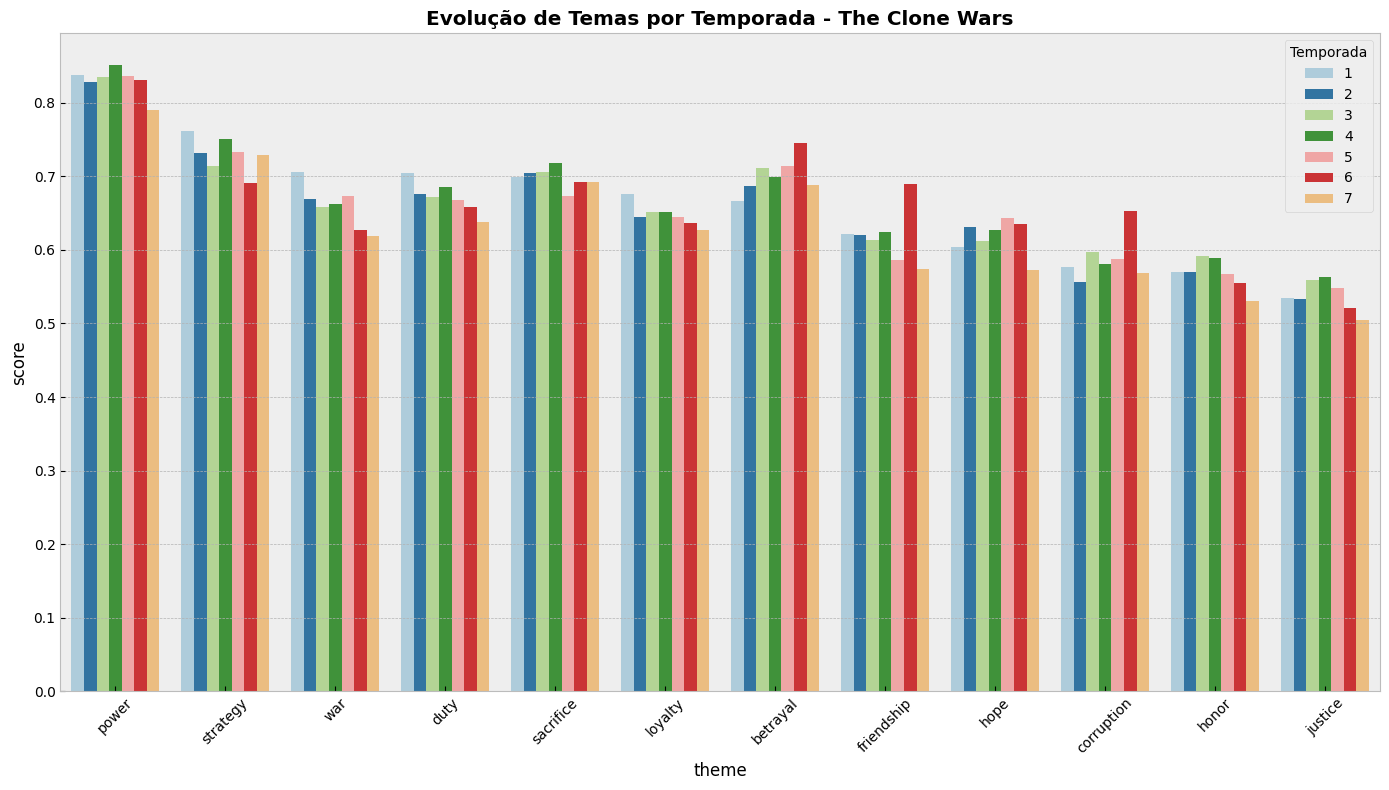

In [ ]:
plot_season_themes(season_themes, themes)

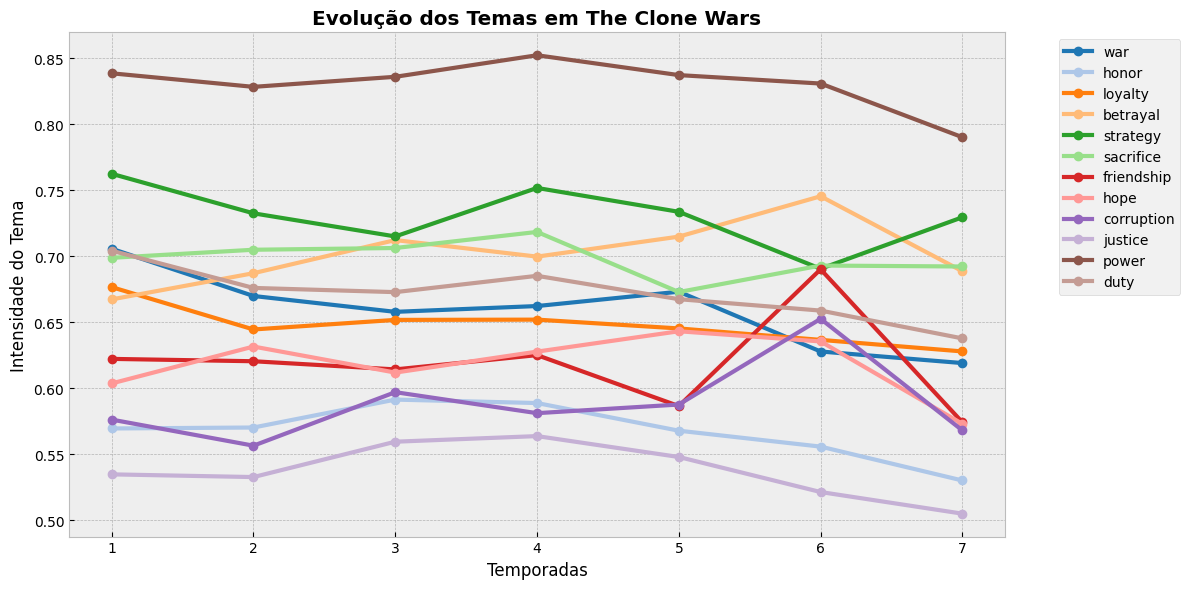

In [ ]:
def plot_theme_evolution(season_themes, themes):
    comparison_data = []
    for season, themes_df in season_themes.items():
        for _, row in themes_df.iterrows():
            comparison_data.append({
                'season': season,
                'theme': row['theme'],
                'score': row['score']
            })
    comparison_df = pd.DataFrame(comparison_data)

    plt.figure(figsize=(12, 6))
    for theme in themes:
        theme_data = comparison_df[comparison_df['theme'] == theme]
        plt.plot(theme_data['season'], theme_data['score'], marker='o', label=theme, linewidth=3)

    plt.title('Evolução dos Temas em The Clone Wars', fontweight='bold')
    plt.xlabel('Temporadas')
    plt.ylabel('Intensidade do Tema')

    season_values = sorted(comparison_df['season'].unique())
    plt.xticks(season_values)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_theme_evolution(season_themes, themes)

# 6. Detecção de temas específicos (Lado Sombrio)

In [ ]:
dark_side_themes = {
  'darkness': {
      'weight': 2.0,
      'keywords': ['dark side', 'sith', 'darth', 'phantom', 'shadow', 'evil',
                  'darkness', 'black', 'night', 'sinister', 'malevolent']
  },
  'corruption': {
      'weight': 1.8,
      'keywords': ['corruption', 'corrupt', 'bribe', 'greed', 'selfish',
                  'decay', 'rot', 'venal', 'avarice', 'cupidity']
  },
  'betrayal': {
      'weight': 2.2,
      'keywords': ['betrayal', 'betray', 'treason', 'traitor', 'deceive',
                  'treachery', 'backstab', 'double-cross', 'duplicity',
                  'order sixty-six', 'order 66']
  },
  'power': {
      'weight': 2.0,
      'keywords': ['power', 'dominate', 'control', 'rule', 'supreme',
                  'command', 'authority', 'mastery', 'dominance', 'overpower']
  },
  'fear': {
      'weight': 1.7,
      'keywords': ['fear', 'terror', 'afraid', 'dread', 'intimidate',
                  'horror', 'panic', 'scare', 'fright', 'apprehension']
  },
  'anger': {
      'weight': 1.9,
      'keywords': ['anger', 'rage', 'hate', 'wrath', 'fury', 'ire',
                  'outrage', 'resentment', 'hostility', 'vengeance']
  },
  'manipulation': {
      'weight': 1.8,
      'keywords': ['manipulate', 'deceive', 'trick', 'scheme', 'plot',
                  'exploit', 'maneuver', 'connive', 'conspire', 'intrigue',
                  'the dark side of the force']
  },
  'death': {
      'weight': 2.1,
      'keywords': ['kill', 'die', 'death', 'murder', 'assassinate',
                  'slay', 'destroy', 'eliminate', 'execute']
  },
  'suffering': {
      'weight': 1.9,
      'keywords': ['pain', 'suffer', 'torment', 'agony', 'anguish',
                  'misery', 'torture', 'despair']
  }
}

In [ ]:
def detect_themes_presence(script, themes):
    if not script or not script.strip():
        return 0.0

    sentences = sent_tokenize(script)
    total_score = 0.0
    counted_sentences = 0

    for sentence in sentences:
        sentence_lower = sentence.lower()
        if len(sentence_lower.split()) < 4:
            continue

        sentence_score = 0.0
        for theme, data in themes.items():
            for keyword in data['keywords']:
                if re.search(r'\b{}\b'.format(re.escape(keyword)), sentence_lower):
                    sentence_score += data['weight']
                    break

        if sentence_score > 0:
            total_score += sentence_score
            counted_sentences += 1

    if counted_sentences == 0:
        return 0.0

    normalized_score = total_score / counted_sentences
    return normalized_score

In [ ]:
df['theme_score'] = df['script'].progress_apply(detect_themes_presence, themes=dark_side_themes)

100%|██████████| 133/133 [00:05<00:00, 23.96it/s]


In [ ]:
def plot_themes_evolution(df, theme_title, color):
  plt.figure(figsize=(12, 6))

  seasons = sorted(df['season'].unique())
  theme_scores = [df[df['season'] == s]['theme_score'].mean() for s in seasons]

  plt.plot(
      seasons,
      theme_scores,
      marker='o',
      linewidth=3,
      markersize=8,
      color=color,
      alpha=0.8,
      label=theme_title
  )

  plt.fill_between(seasons, theme_scores, alpha=0.2, color=color)
  plt.title(f'Evolução do {theme_title} por temporada',
            fontsize=14, fontweight='bold')
  plt.xlabel('Temporada')
  plt.ylabel('Intensidade')
  plt.xticks(seasons)
  plt.legend()
  plt.tight_layout()
  plt.show()

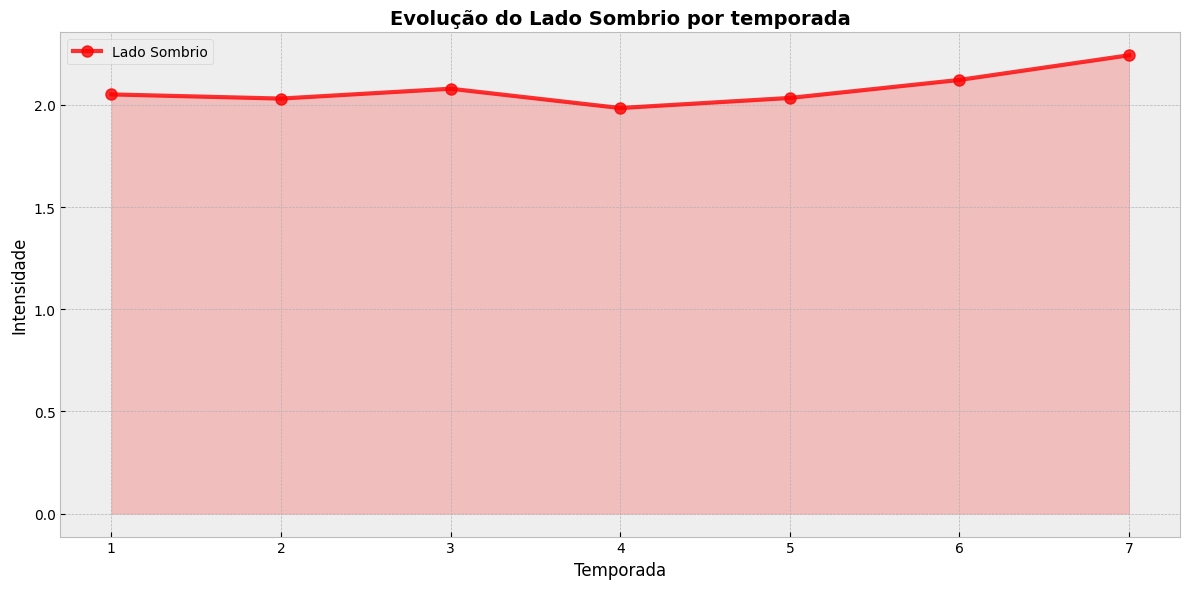

In [ ]:
plot_themes_evolution(df, 'Lado Sombrio', 'red')